# CIS 400 Project Part 5

Pre-processing （This section do NOT need to rerun）

In [1]:
# requires tensorflow=2.3.0
from transformers import pipeline

In [5]:
sentiment_analysis = pipeline("sentiment-analysis")

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [6]:
# tweets: {'TweetID': ['UserID', 'Source','Text', 'CreatedDate']}
tweets = load_data("tweetinfo.csv")

In [10]:
tweets_sentence = [tweets[k][2] for k in tweets.keys()]

In [20]:
# sentiment analysis
def senti_analysis(tweets, batch = 1000):
    result = []
    size = len(tweets)
    for i in range(0, size, batch):
        x = i
        result += sentiment_analysis(tweets[x:x+batch])
        print("finished:", i+batch)
    return result

In [21]:
#starting at 11:35 am
tweets_sentiments = senti_analysis(tweets_sentence)

finished: 1000
finished: 2000
finished: 3000
finished: 4000
finished: 5000
finished: 6000
finished: 7000
finished: 8000
finished: 9000
finished: 10000
finished: 11000
finished: 12000
finished: 13000
finished: 14000
finished: 15000
finished: 16000
finished: 17000
finished: 18000
finished: 19000
finished: 20000
finished: 21000
finished: 22000
finished: 23000
finished: 24000
finished: 25000
finished: 26000
finished: 27000
finished: 28000
finished: 29000
finished: 30000
finished: 31000
finished: 32000
finished: 33000
finished: 34000
finished: 35000
finished: 36000
finished: 37000
finished: 38000
finished: 39000
finished: 40000
finished: 41000
finished: 42000
finished: 43000
finished: 44000
finished: 45000
finished: 46000
finished: 47000
finished: 48000
finished: 49000
finished: 50000
finished: 51000
finished: 52000
finished: 53000
finished: 54000
finished: 55000
finished: 56000
finished: 57000
finished: 58000
finished: 59000
finished: 60000
finished: 61000
finished: 62000
finished: 63000
f

finished: 490000
finished: 491000
finished: 492000
finished: 493000
finished: 494000
finished: 495000
finished: 496000
finished: 497000
finished: 498000
finished: 499000
finished: 500000
finished: 501000
finished: 502000
finished: 503000
finished: 504000
finished: 505000
finished: 506000
finished: 507000
finished: 508000
finished: 509000
finished: 510000
finished: 511000
finished: 512000
finished: 513000
finished: 514000
finished: 515000
finished: 516000
finished: 517000
finished: 518000
finished: 519000
finished: 520000
finished: 521000
finished: 522000
finished: 523000
finished: 524000
finished: 525000
finished: 526000
finished: 527000
finished: 528000
finished: 529000
finished: 530000
finished: 531000
finished: 532000
finished: 533000
finished: 534000
finished: 535000
finished: 536000
finished: 537000
finished: 538000
finished: 539000
finished: 540000
finished: 541000
finished: 542000
finished: 543000
finished: 544000
finished: 545000
finished: 546000
finished: 547000
finished: 5480

finished: 972000
finished: 973000
finished: 974000
finished: 975000
finished: 976000
finished: 977000
finished: 978000
finished: 979000
finished: 980000
finished: 981000
finished: 982000
finished: 983000
finished: 984000
finished: 985000
finished: 986000
finished: 987000
finished: 988000
finished: 989000
finished: 990000
finished: 991000
finished: 992000
finished: 993000
finished: 994000
finished: 995000
finished: 996000
finished: 997000
finished: 998000
finished: 999000
finished: 1000000
finished: 1001000
finished: 1002000
finished: 1003000
finished: 1004000
finished: 1005000
finished: 1006000
finished: 1007000
finished: 1008000
finished: 1009000
finished: 1010000
finished: 1011000
finished: 1012000
finished: 1013000
finished: 1014000
finished: 1015000
finished: 1016000
finished: 1017000
finished: 1018000
finished: 1019000
finished: 1020000
finished: 1021000
finished: 1022000
finished: 1023000
finished: 1024000
finished: 1025000
finished: 1026000
finished: 1027000
finished: 1028000
fi

finished: 1429000
finished: 1430000
finished: 1431000
finished: 1432000
finished: 1433000
finished: 1434000
finished: 1435000
finished: 1436000
finished: 1437000
finished: 1438000
finished: 1439000
finished: 1440000
finished: 1441000
finished: 1442000
finished: 1443000
finished: 1444000
finished: 1445000
finished: 1446000
finished: 1447000
finished: 1448000
finished: 1449000
finished: 1450000
finished: 1451000
finished: 1452000
finished: 1453000
finished: 1454000
finished: 1455000
finished: 1456000
finished: 1457000
finished: 1458000
finished: 1459000
finished: 1460000
finished: 1461000
finished: 1462000
finished: 1463000
finished: 1464000
finished: 1465000
finished: 1466000
finished: 1467000
finished: 1468000
finished: 1469000
finished: 1470000
finished: 1471000
finished: 1472000
finished: 1473000
finished: 1474000
finished: 1475000
finished: 1476000
finished: 1477000
finished: 1478000
finished: 1479000
finished: 1480000
finished: 1481000
finished: 1482000
finished: 1483000
finished: 

finished: 1885000
finished: 1886000
finished: 1887000
finished: 1888000
finished: 1889000
finished: 1890000
finished: 1891000
finished: 1892000
finished: 1893000
finished: 1894000
finished: 1895000
finished: 1896000
finished: 1897000
finished: 1898000
finished: 1899000
finished: 1900000
finished: 1901000
finished: 1902000
finished: 1903000
finished: 1904000
finished: 1905000
finished: 1906000
finished: 1907000
finished: 1908000
finished: 1909000
finished: 1910000
finished: 1911000
finished: 1912000
finished: 1913000
finished: 1914000
finished: 1915000
finished: 1916000
finished: 1917000
finished: 1918000
finished: 1919000
finished: 1920000
finished: 1921000
finished: 1922000
finished: 1923000
finished: 1924000
finished: 1925000
finished: 1926000
finished: 1927000
finished: 1928000
finished: 1929000
finished: 1930000
finished: 1931000
finished: 1932000
finished: 1933000
finished: 1934000
finished: 1935000
finished: 1936000
finished: 1937000
finished: 1938000
finished: 1939000
finished: 

finished: 2341000
finished: 2342000
finished: 2343000
finished: 2344000
finished: 2345000
finished: 2346000
finished: 2347000
finished: 2348000
finished: 2349000
finished: 2350000
finished: 2351000
finished: 2352000
finished: 2353000
finished: 2354000
finished: 2355000
finished: 2356000
finished: 2357000
finished: 2358000
finished: 2359000
finished: 2360000
finished: 2361000
finished: 2362000
finished: 2363000
finished: 2364000
finished: 2365000
finished: 2366000
finished: 2367000
finished: 2368000
finished: 2369000
finished: 2370000
finished: 2371000
finished: 2372000
finished: 2373000
finished: 2374000
finished: 2375000
finished: 2376000
finished: 2377000
finished: 2378000
finished: 2379000
finished: 2380000
finished: 2381000
finished: 2382000
finished: 2383000
finished: 2384000
finished: 2385000
finished: 2386000
finished: 2387000
finished: 2388000
finished: 2389000
finished: 2390000
finished: 2391000
finished: 2392000
finished: 2393000
finished: 2394000
finished: 2395000
finished: 

finished: 2797000
finished: 2798000
finished: 2799000
finished: 2800000
finished: 2801000
finished: 2802000
finished: 2803000
finished: 2804000
finished: 2805000
finished: 2806000
finished: 2807000
finished: 2808000
finished: 2809000
finished: 2810000
finished: 2811000
finished: 2812000
finished: 2813000
finished: 2814000
finished: 2815000
finished: 2816000
finished: 2817000
finished: 2818000
finished: 2819000
finished: 2820000
finished: 2821000
finished: 2822000
finished: 2823000
finished: 2824000
finished: 2825000
finished: 2826000
finished: 2827000
finished: 2828000
finished: 2829000
finished: 2830000
finished: 2831000
finished: 2832000
finished: 2833000
finished: 2834000
finished: 2835000
finished: 2836000
finished: 2837000
finished: 2838000
finished: 2839000
finished: 2840000
finished: 2841000
finished: 2842000
finished: 2843000
finished: 2844000
finished: 2845000
finished: 2846000
finished: 2847000
finished: 2848000
finished: 2849000
finished: 2850000
finished: 2851000
finished: 

finished: 3253000
finished: 3254000
finished: 3255000
finished: 3256000
finished: 3257000
finished: 3258000
finished: 3259000
finished: 3260000
finished: 3261000
finished: 3262000
finished: 3263000
finished: 3264000
finished: 3265000
finished: 3266000
finished: 3267000
finished: 3268000
finished: 3269000
finished: 3270000
finished: 3271000
finished: 3272000
finished: 3273000
finished: 3274000
finished: 3275000
finished: 3276000
finished: 3277000
finished: 3278000
finished: 3279000
finished: 3280000
finished: 3281000
finished: 3282000
finished: 3283000
finished: 3284000
finished: 3285000


In [22]:
# attach sentiments to tweets
def attach_sentiments(tweets, sentiments):
    i = 0
    result = tweets
    for k in tweets.keys():
        result[k].append(sentiments[i])
        i += 1
    return result

In [23]:
tweets_new = attach_sentiments(tweets, tweets_sentiments)

In [27]:
save_data(tweets_new, "tweetsentiments.csv")

writing finish


Section 1 -- Load Data

In [3]:
import csv

In [4]:
# read data
def load_data(filename):
    result = {}
    with open(filename, newline='', encoding="utf8") as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
        for row in spamreader:
            result[row[0]] = row[1:]
    return result

In [5]:
# Save data into csv files
def save_data(dic, filename):
    with open(filename,'w', newline='', encoding="utf8") as csvfile:
        csvwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
        for k in dic.keys():
            csvwriter.writerow([k] + dic[k])
        print('writing finish')

In [6]:
# tweets_sentiments: {'TweetID': ['UserID', 'Source','Text', 'CreatedDate', 'Sentiments']}
tweets_sentiments = load_data("tweetsentiments.csv")

# tweets_emotions_NLTK: {'TweetID': ['emotion_score']}
tweets_emotions_NLTK = load_data("tweetemotion.csv")

# users: {'UserID': ['UserName','followers_count', 'friends_count', 'FriendID']}
users = load_data("userinfo.csv")

Section 2 -- Comparsion of Sentiment Algorithms

In [91]:
# Here we compare results between scoring method and pre-trained neural network classification models on sentiment analysis

In [15]:
import matplotlib.pyplot as plt

In [25]:
# Plot distributions
def plot_distribution(points, title_and_xylabels, save_filename, bin_size = 21):
    plt.figure(figsize=(10,8))
    plt.hist(points, bins = bin_size, range = (-1.05,1.05))

    plt.xlabel(title_and_xylabels[1])
    plt.ylabel(title_and_xylabels[2])
    plt.title(title_and_xylabels[0])
    plt.savefig(save_filename)
    plt.show()

In [26]:
# prepare sentiments collected by DistilBERT (NeruIPS '19)
def distilBERT_sentiments(tweets_sentiments):
    result = {}
    for k in tweets_sentiments.keys():
        dict_sentiment = eval(tweets_sentiments[k][4])
        if dict_sentiment['label'] == 'NEGATIVE':
            result[k] = -dict_sentiment['score']
        else:
            result[k] = dict_sentiment['score']
    return result

In [27]:
emotions_NLTK = [float(v[0]) for v in tweets_emotions_NLTK.values()]

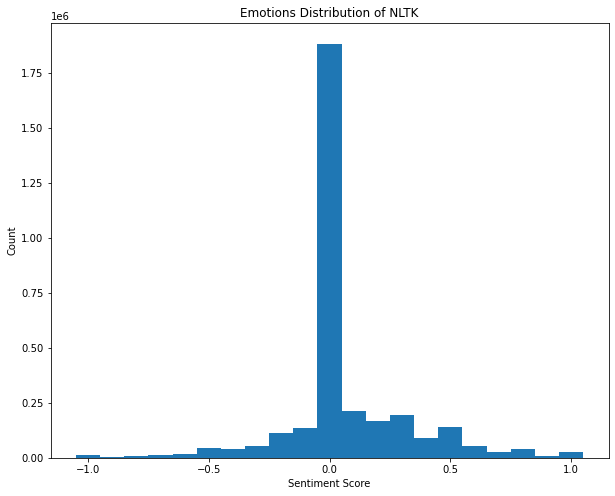

In [10]:
plot_distribution(emotions_NLTK, 
                  ['Emotions Distribution of NLTK', 'Sentiment Score', 'Count'], 
                  'emotions_NLTK_distribution.png')

# Most of tweets have 0 sentiment scores!!
# It is hard to study correlation between sentiments and other features.

In [28]:
sentiments_distilBERT = distilBERT_sentiments(tweets_sentiments)
sentiments_distilBERT # sentiments_distilBERT: {'TweetID': ['Emotional Value']}

{'105': -0.9970303177833557,
 '106': 0.9727376699447632,
 '107': -0.990226149559021,
 '108': 0.9982147216796875,
 '109': 0.8010407090187073,
 '110': -0.9994679689407349,
 '111': 0.9861118793487549,
 '112': -0.9797460436820984,
 '113': -0.9959220886230469,
 '114': -0.9779990911483765,
 '115': -0.998418927192688,
 '116': -0.9947896599769592,
 '117': 0.806771457195282,
 '118': 0.9863671064376831,
 '119': -0.993120551109314,
 '120': -0.9984928965568542,
 '121': -0.9959548115730286,
 '122': -0.9988399744033813,
 '123': -0.9992970824241638,
 '124': 0.9900333285331726,
 '125': 0.9982147216796875,
 '126': -0.5490931868553162,
 '127': 0.994513750076294,
 '128': -0.9974790215492249,
 '129': -0.9993804693222046,
 '130': -0.9689813256263733,
 '131': 0.9900333285331726,
 '132': -0.9965903162956238,
 '133': 0.9900333285331726,
 '134': 0.9859874248504639,
 '135': -0.9953274726867676,
 '136': -0.9995466470718384,
 '137': -0.9970303177833557,
 '138': -0.9970303177833557,
 '139': -0.997717022895813,
 '1

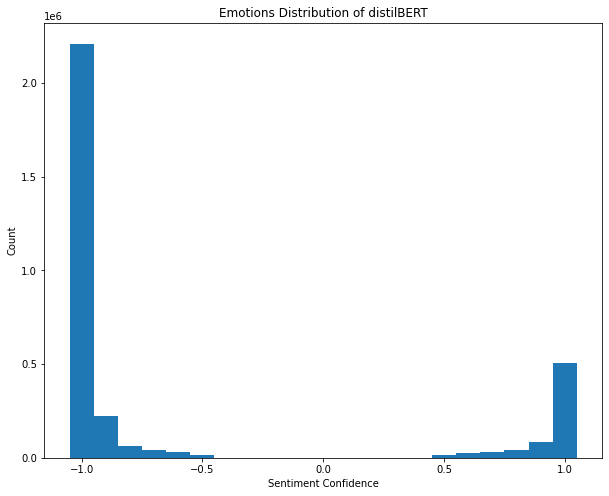

In [12]:
plot_distribution(sentiments_distilBERT.values(), 
                  ['Emotions Distribution of distilBERT', 'Sentiment Confidence', 'Count'], 
                  'emotions_distilBERT_distribution.png')

# Most tweets are classified into either 'positive' or 'negative' with high confidence
# Note that these two are actually completely different methods (Scoring and Classification), 
# binary clasification methods are more suitable for our future tasks rather than scoreing methods. 

In [13]:
# Here we show some actual examples of two methods, how distilBERT is more advanced
print('---------------------example 1---------------------')
print('tweet:', tweets_sentiments['105'][2])
print('NLTK_score:', tweets_emotions_NLTK['105'][0])
print('distilBERT_Result:', tweets_sentiments['105'][4])

print('\n---------------------example 2---------------------')
print('tweet:', tweets_sentiments['106'][2])
print('NLTK_score:', tweets_emotions_NLTK['106'][0])
print('distilBERT_Result:', tweets_sentiments['106'][4])

print('\n---------------------example 3---------------------')
print('tweet:', tweets_sentiments['115'][2])
print('NLTK_score:', tweets_emotions_NLTK['115'][0])
print('distilBERT_Result:', tweets_sentiments['115'][4])

---------------------example 1---------------------
tweet: RT @normanswan: Israel has just done a deal with Moderna for a variant specific vaccine. Why haven’t we?
NLTK_score: 0.0
distilBERT_Result: {'label': 'NEGATIVE', 'score': 0.9970303177833557}

---------------------example 2---------------------
tweet: RT @sanchezcastejon: Spain is commited to equal and universal access to vaccines, @selenagomez. Just this week, I have announced that we wi…
NLTK_score: 0.0
distilBERT_Result: {'label': 'POSITIVE', 'score': 0.9727376699447632}

---------------------example 3---------------------
tweet: RT @AskAnshul: A lobby is urging to import Pfizer vaccine since January. They just want India to buy Pfizer. They don't care about its cost…
NLTK_score: 0.0
distilBERT_Result: {'label': 'NEGATIVE', 'score': 0.998418927192688}


Section 3 -- Sentiments over Time

In [14]:
# plot sentments overtime
# Here we set a threshold to consider confidence score <= 0.95 as Neutal tweets
import datetime as dt

In [15]:
def judge_sentiment(score):
    if score > 0.95:
        return 'Positive'
    elif score < -0.95:
        return 'Negative'
    else:
        return 'Neutral'

def count_sentiment(tweets_sentiments, sentiments_distilBERT):
    result = {}
    for k in tweets_sentiments.keys():
        d_t = dt.datetime.strptime(tweets_sentiments[k][3], '%Y-%m-%d %H:%M:%S')
        day = d_t.date()
        score = sentiments_distilBERT[k]
        if day not in result.keys():
            result[day] = {'Positive': 0, 'Negative': 0 ,'Neutral':0}
            
        result[day][judge_sentiment(score)] += 1
            
    return result

In [16]:
def plot_sentiment(data, title_and_xylabels, save_filename):
    date = []
    negative = []
    positive = []
    
    start_date = dt.date(2019, 4, 26)
    end_date = dt.date(2021, 4, 26)
    delta = dt.timedelta(days = 1)
    while start_date <= end_date:
        date.append(start_date)
        if start_date in data.keys():
            da = data[start_date]
            total = da['Positive'] + da['Negative'] + da['Neutral']
            positive.append(da['Positive']/total)
            negative.append(-da['Negative']/total)
        else:
            positive.append(0)
            negative.append(0)
        start_date += delta 
    
    fig = plt.figure(figsize=(25,8))
    plt.xlabel(title_and_xylabels[1])
    plt.ylabel(title_and_xylabels[2])
    plt.title(title_and_xylabels[0])
    plt.axvline(x = dt.date(2020,3,1), color = 'y', linewidth=10, alpha=0.7)
    plt.plot([dt.date(2020,3,1), dt.date(2021,4,26)], [-0.64, -0.7], color = 'y', linewidth=10, alpha=0.7)
    plt.plot([dt.date(2020,3,1), dt.date(2021,4,26)], [0.18, 0.12], color = 'y', linewidth=10, alpha=0.7)
    ax = plt.subplot(111)
    ax.bar(date, negative, width=1, color='b', alpha=0.9)
    ax.bar(date, positive, width=1, color='r', alpha=0.9)
    
    fig.savefig(save_filename)
    plt.show()

In [17]:
senti_over_time = count_sentiment(tweets_sentiments, sentiments_distilBERT)

<ipython-input-16-bb46b30f4964>:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.subplot(111)


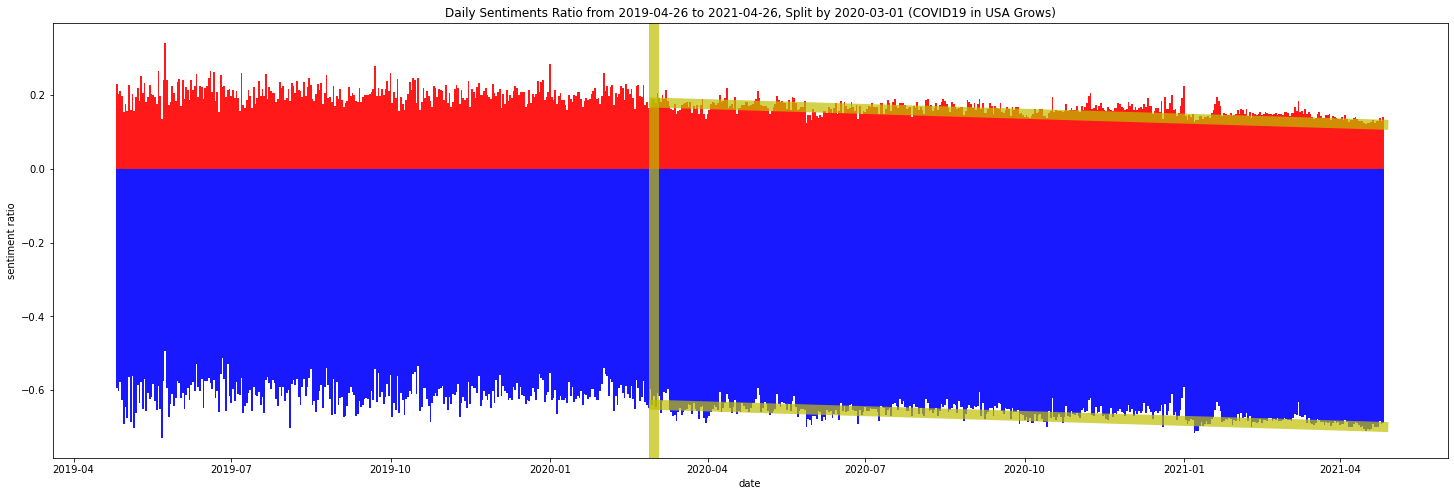

In [18]:
plot_sentiment(senti_over_time, 
               ['Daily Sentiments Ratio from 2019-04-26 to 2021-04-26, Split by 2020-03-01 (COVID19 in USA Grows)', 'date', 'sentiment ratio'], 
               'sentiments over time.png')

In [ ]:
# Here we conclude:
# 1. people on twitter are mostly negative (roughly 20% positve/ 60% negative)

# 2. before the pandemic people's sentiments are relatively stable

# 3. through the pandemic people's sentiments become more and more negative 
# (This can be shown by simple linear regression, we will include it in report)

Section 4 -- Sentiments vs. Popularity over COVID19 pandemic

In [184]:
# Here we discuss whether sentiments are related with user's popularities (followers/friends)
# We use K-means of euclidean distance to clustering users 
# However, K-means is super sensitive to distances, we log our followers/friends count to mitigate this

In [7]:
from sklearn.cluster import KMeans
import numpy as np
import math

In [8]:
# transfer to 2-dimensional points after log followers/friendes
def prepare_points(user_data):
    result = {}
    for k in user_data.keys():
        result[k] = (math.log10(int(user_data[k][1]) + 1), math.log10(int(user_data[k][2]) + 1))
    return result

In [9]:
# elbow method to select k 
# We measure Within Cluster Sum of Squares (WCSS) for different k, then select a k at 'elbow' of plot
def elbow_k_selecting(points):
    X = np.array(list(points.values()))
    
    wcss = []
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(X)
        wcss.append(kmeans.inertia_)
    plt.plot(range(1, 11), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.savefig('elbow k means.png')
    plt.show()

In [10]:
# K-mean clustering 
def preform_Kmeans(points, k = 4):
    results = {}
    
    X = np.array(list(points.values()))
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(X)
    labels = kmeans.labels_
    userids = list(points.keys())
    for i in range(len(userids)):
        results[userids[i]] = labels[i]
    
    return kmeans.cluster_centers_, results

In [11]:
# sentiments of different groups during COVID19 pandemic(from 2020-03-01)
def sentiments_towards_popularity(tweets_sentiments, sentiments_distilBERT, user_clusters):
    result = {'Positive':[0,0,0,0], 'Negative':[0,0,0,0], 'Neutral':[0,0,0,0]}
    
    for k in tweets_sentiments.keys():
        d_t = dt.datetime.strptime(tweets_sentiments[k][3], '%Y-%m-%d %H:%M:%S')
        day = d_t.date()
        if day >= dt.date(2020, 3, 1):
            user_id = tweets_sentiments[k][0]
            group_id = user_clusters[user_id]
            sentiment = judge_sentiment(sentiments_distilBERT[k])
            result[sentiment][group_id] += 1
    return result

In [12]:
# plot sentiments over group
def plot_sentiment_group(sentiments_over_group):
    group_total = [0]*4
    for i in range(4):
        group_total[i] = sentiments_over_group['Negative'][i]+sentiments_over_group['Positive'][i]+sentiments_over_group['Neutral'][i]
    
    N = 4
    positive = (sentiments_over_group['Positive'][2]/group_total[2], sentiments_over_group['Positive'][0]/group_total[0], 
               sentiments_over_group['Positive'][1]/group_total[1], sentiments_over_group['Positive'][3]/group_total[3])
    neutral = (sentiments_over_group['Neutral'][2]/group_total[2], sentiments_over_group['Neutral'][0]/group_total[0], 
               sentiments_over_group['Neutral'][1]/group_total[1], sentiments_over_group['Neutral'][3]/group_total[3])
    negative = (sentiments_over_group['Negative'][2]/group_total[2], sentiments_over_group['Negative'][0]/group_total[0], 
               sentiments_over_group['Negative'][1]/group_total[1], sentiments_over_group['Negative'][3]/group_total[3])
    

    ind = np.arange(N) 
    width = 0.25       
    plt.bar(ind, positive, width, label='Positive', color = 'r')
    plt.bar(ind + width, neutral, width, label='Neutral', color = 'y')
    plt.bar(ind + 2*width, negative, width, label='Negative', color = 'b')

    plt.ylim((0,1))
    plt.ylabel('Ratio')
    plt.xlabel('Popularity')
    plt.title('Sentiments over User Popularity')

    plt.xticks(ind + width, ('Low', 'Medium', 'High', 'ExtremeHigh'))
    plt.legend(loc='best')
    plt.savefig("sentiment_over_popularity.png")
    plt.show()

In [13]:
user_points = prepare_points(users) #user_points: {'UserID': ['followers_count', 'friends_count']}

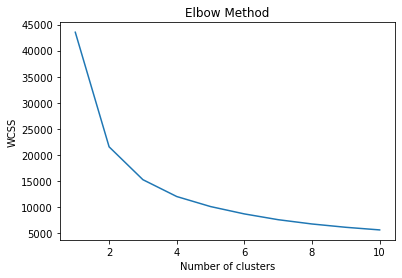

In [16]:
elbow_k_selecting(user_points)
# from this plot we select k=4

In [17]:
centers, user_clusters = preform_Kmeans(user_points)

In [22]:
# these are centers of each clusters
# We name these clusters by:
# 0 -- medium popularity group
# 1 -- high popularity group
# 2 -- low popularity group
# 3 -- extremely high popularity group
print(centers)

[[3.3805696  3.35221047]
 [1.78778208 2.22947507]
 [2.63955523 2.79421643]
 [4.59599319 3.35030803]]


In [222]:
sentiments_over_group = sentiments_towards_popularity(tweets_sentiments, sentiments_distilBERT, user_clusters)

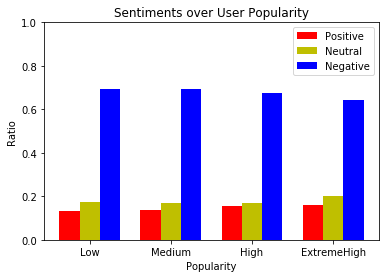

In [245]:
plot_sentiment_group(sentiments_over_group)

In [ ]:
# Here we conclude accounts with higher popularity are slightly more positive
# Maybe because all official accounts are in 'ExtremeHigh' group